In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 7
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 12

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = "\\usepackage{subdepth}, \\usepackage{type1cm}"

## Example: Concentric Circles

We will use `make_circles` data generator available in `sklearn`. Let us generate 400 samples lying on two concentric circles.

In [3]:
# load libraries and set plot parameters
import numpy as np
import prettytable as pt
import pprint
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import cluster, datasets
np.random.seed(0)
n_samples = 400
X, y = datasets.make_circles(n_samples=n_samples, factor=.4, noise=.1)

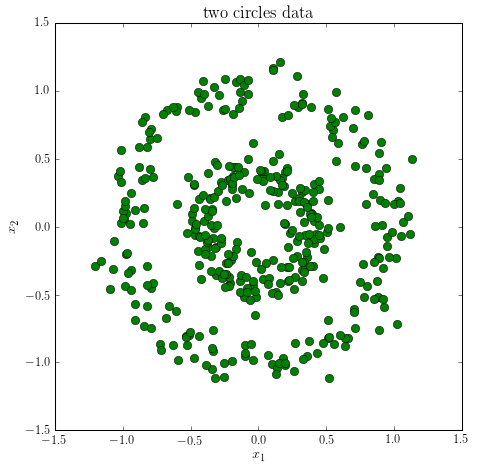

In [5]:
plt.title("two circles data")
plt.plot(X[:,0],X[:,1],'go')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axes().set_aspect('equal')

Now we will compare various clustering algorithms on this dataset. The following helper function will be used to execute clustering and plot the results. 

In [7]:
def fit_and_plot(algorithm,title):
    col = ['bo','ro','co', 'mo','ko']
    algorithm.fit(X)
    n_clusters = algorithm.n_clusters
    lab = algorithm.labels_
    reds = lab == 0
    blues = lab == 1
    for jj in range(n_clusters):
        plt.plot(X[lab == jj, 0], X[lab == jj, 1], col[jj])
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title(title)
    plt.axes().set_aspect('equal')    

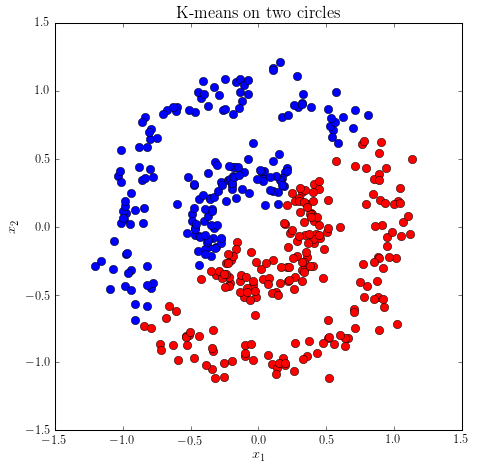

In [8]:
#run k-means
kmeans = cluster.KMeans(n_clusters=2)
fit_and_plot(kmeans, "K-means on two circles")

K-means does not deal well with such nonlinear cluster structure. Let us instead try spectral clustering using 10 nearest neighbours to construct the graph.

{   'affinity': 'nearest_neighbors',
    'assign_labels': 'kmeans',
    'coef0': 1,
    'degree': 3,
    'eigen_solver': 'arpack',
    'eigen_tol': 0.0,
    'gamma': 1.0,
    'kernel_params': None,
    'n_clusters': 2,
    'n_init': 10,
    'n_jobs': 1,
    'n_neighbors': 10,
    'random_state': None}


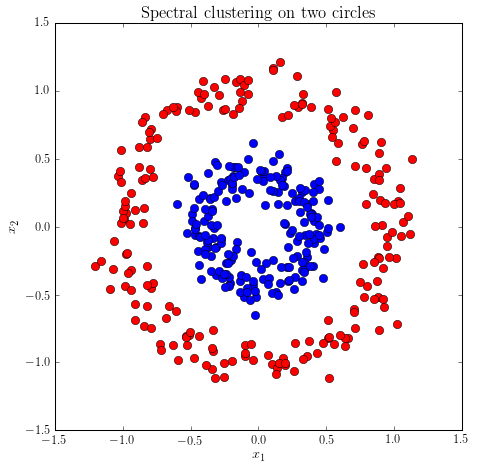

In [9]:
spectralnn = cluster.SpectralClustering(n_clusters=2,
                                eigen_solver='arpack',
                                affinity='nearest_neighbors',
                                n_neighbors=10)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(spectralnn.get_params())
fit_and_plot(spectralnn,"Spectral clustering on two circles")

Success! Let us visualise the graph corresponding to the affinity matrix. 

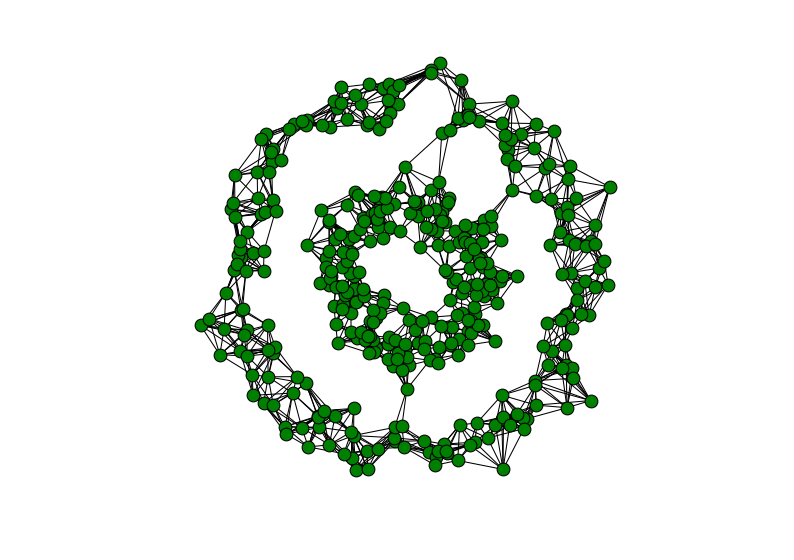

In [11]:
W = spectralnn.affinity_matrix_
G=nx.from_scipy_sparse_matrix(W)
nx.draw(G,X,node_color='g',node_size=150)
plt.axis('equal')
plt.show()

We do see edges joining the two circles, but a fairly small number as compared to the number of edges within each of the circles.

Next, let us investigate the eigenvalues.

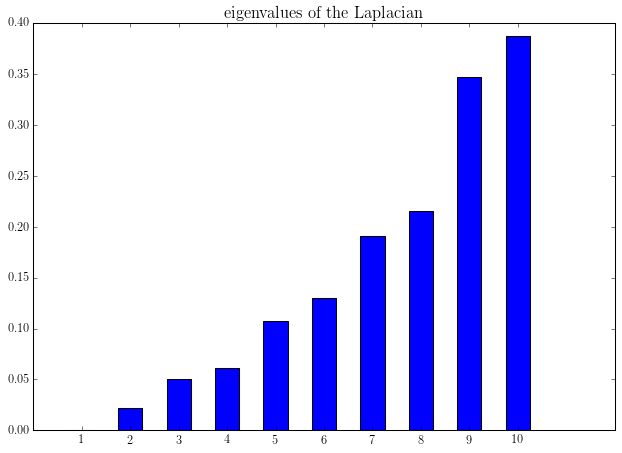

In [12]:
d=np.reshape(np.array(W.sum(axis=0)),n_samples)
D=np.diag(d)
L=D-W
lmbda, U = np.linalg.eigh(L)
num_eigs = 10
plt.bar(1+np.arange(num_eigs),lmbda[:num_eigs],width=0.5,align='center')
plt.xticks(1+np.arange(num_eigs))
plt.title("eigenvalues of the Laplacian")
plt.show()

The five smallest eigenvalues are {{ [float('%.3g' % lmbda[i]) for i in range(5)] }}. Ideally, if the "true" number of clusters is $K$, one should expect a large gap between eigenvalues $K$ and $K+1$, allowing one to select the number of clusters based on this gap. This does not always happen - hence it may not be clear how many clusters to select. 

Consider the data representation that we obtain from the first two eigenvectors of the Laplacian -- this is the data representation on which k-Means is run. We see that the clusters are well separated in this representation.

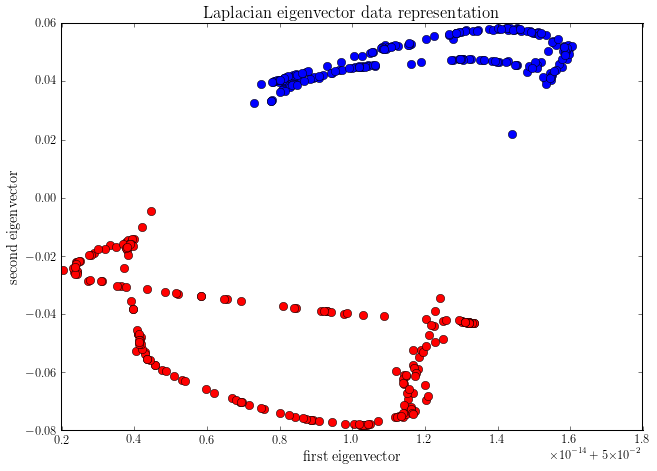

In [19]:
reds = y == 0
blues = y == 1

plt.plot(U[reds,0],U[reds,1],'ro')
plt.plot(U[blues,0],U[blues,1],'bo')
plt.xlabel("first eigenvector")
plt.ylabel("second eigenvector")
plt.title("Laplacian eigenvector data representation")
plt.show()

Another way to visualise the split that arose in this new representation is to consider the coefficients in each eigenvector for the two clusters. The first eigenvector is essentially constant. The second eigenvector separates the two clusters.

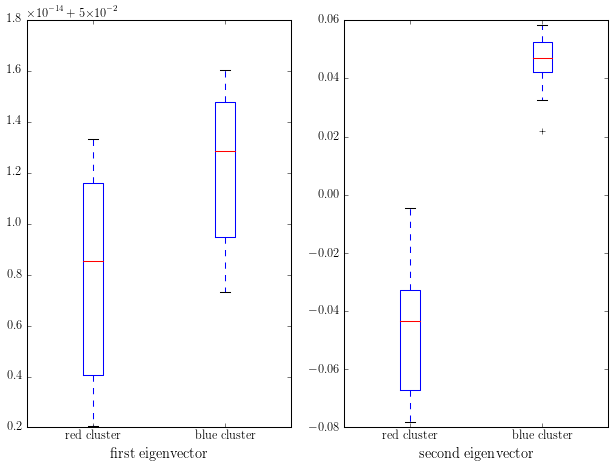

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.boxplot([U[reds,0],U[blues,0]])
ax1.set_xlabel("first eigenvector")
ax1.set_xticklabels(["red cluster", "blue cluster"])
ax2.boxplot([U[reds,1],U[blues,1]])
ax2.set_xlabel("second eigenvector")
ax2.set_xticklabels(["red cluster", "blue cluster"])
plt.show()

There is also a large gap between the 4th and the 5th eigenvalue - so let us try four clusters instead. What do you conclude?

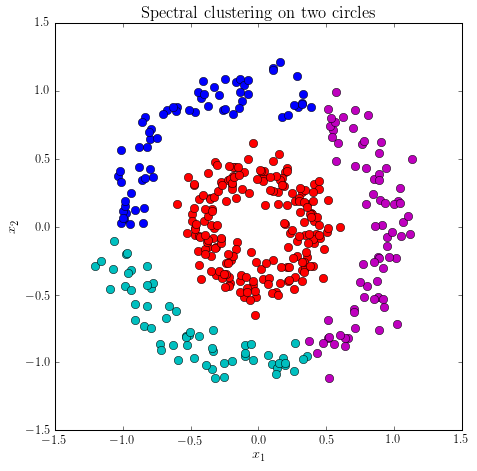

In [13]:
spectralnn4 = cluster.SpectralClustering(n_clusters=4,
                                eigen_solver='arpack',
                                affinity='nearest_neighbors',
                                n_neighbors=10)
fit_and_plot(spectralnn4,"Spectral clustering on two circles")